In [1]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
#print('done')

In [2]:
#Load income dataset

dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
row_names = ["Age", "Workclass", "Fnlwgt", "Education", "EducationNum", "MaritalStatus",
        "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss",
        "HoursPerWeek", "Country", "Income"]
us_adult_income = pd.read_csv(dataset, names=row_names,na_values=[' ?'])

In [3]:

del us_adult_income['CapitalGain']
del us_adult_income['CapitalLoss']
del us_adult_income['Education']
del us_adult_income['Relationship']
del us_adult_income['Country']

#print(us_adult_income)

one_hot_encoding = pd.get_dummies(us_adult_income)
one_hot_encoding.fillna(one_hot_encoding.mean(),inplace=True)
one_hot_encoding["Income"] = one_hot_encoding['Income_ >50K']
del one_hot_encoding['Income_ <=50K']
del one_hot_encoding['Income_ >50K']

X = one_hot_encoding.iloc[:,0:-1]
Y = one_hot_encoding.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

In [4]:
X_train.describe()
X_train.shape

(24420, 40)

In [5]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

yPredRf = rf.predict(X_test)
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      6214
           1       0.74      0.40      0.52      1927

    accuracy                           0.82      8141
   macro avg       0.79      0.68      0.71      8141
weighted avg       0.81      0.82      0.80      8141



Text(0, 0.5, 'Cross-validated accuracy')

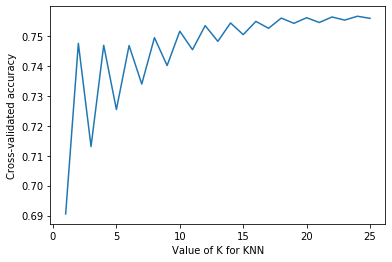

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Number of k from 1 to 26
k_range = range(1, 26)
k_scores = []
# Calculate cross validation score for every k number from 1 to 26
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())
    
%matplotlib inline
# Plot accuracy for every k number between 1 and 26
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [7]:
# Train the model and predict for k=16
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      6214
           1       0.35      0.02      0.04      1927

    accuracy                           0.76      8141
   macro avg       0.56      0.50      0.45      8141
weighted avg       0.67      0.76      0.67      8141



In [8]:
gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)


# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      6214
           1       0.65      0.18      0.29      1927

    accuracy                           0.78      8141
   macro avg       0.72      0.58      0.58      8141
weighted avg       0.76      0.78      0.73      8141



In [9]:
xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6214
           1       0.69      0.59      0.63      1927

    accuracy                           0.84      8141
   macro avg       0.78      0.75      0.77      8141
weighted avg       0.83      0.84      0.83      8141



In [10]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, Y_train)

yPredSVM = svclassifier.predict(X_test)
print(metrics.classification_report(Y_test, yPredSVM))

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


              precision    recall  f1-score   support

           0       0.77      0.98      0.86      6214
           1       0.49      0.06      0.11      1927

    accuracy                           0.76      8141
   macro avg       0.63      0.52      0.49      8141
weighted avg       0.70      0.76      0.68      8141



In [15]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                class_names=['Income < 50K', 'Income > 50k'], verbose=True, mode='classification')

j = 2

print("KNN ", "Predicted: ", yPredKNN[j], " ", "Actual: ", Y_test.values[j])
exp = explainer.explain_instance(X_test.values[j], knn.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

print("GNB ", "Predicted: ", yPredGNB[j], " ", "Actual: ", Y_test.values[j])
exp = explainer.explain_instance(X_test.values[j], gnb.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

print("RF ", "Predicted: ", yPredRf[j], " ", "Actual: ", Y_test.values[j])
exp = explainer.explain_instance(X_test.values[j], rf.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

KNN  Predicted:  0   Actual:  1
Intercept 0.2049488635878939
Prediction_local [0.24275491]
Right: 0.3333333333333333


GNB  Predicted:  0   Actual:  1
Intercept 0.16093091126348497
Prediction_local [0.38957117]
Right: 0.324157222747309


RF  Predicted:  1   Actual:  1
Intercept 0.0336629517435347
Prediction_local [0.53225091]
Right: 0.571232377844581


Intercept 0.3993631394895186
Prediction_local [1.01588401]
Right: 0.9445828999020998
Intercept 0.6743229809000312
Prediction_local [0.89870654]
Right: 0.9164661243799183
Intercept 0.4561945917026223
Prediction_local [1.08224013]
Right: 0.9840175587622317
Intercept -0.02955534614538835
Prediction_local [0.499828]
Right: 0.6550978706370978
Intercept -0.033029454336352154
Prediction_local [0.51156781]
Right: 0.6396338154303669
Intercept 0.5786797293849911
Prediction_local [0.88942093]
Right: 0.954559468149865
Intercept 0.9267115473101846
Prediction_local [0.64472593]
Right: 0.6925860164645445
Intercept 0.6301805374803547
Prediction_local [1.00629208]
Right: 0.9304411782568925
Intercept 0.8014909761580681
Prediction_local [0.74268597]
Right: 0.7641221877496492
Intercept 0.5350270775911912
Prediction_local [1.05442768]
Right: 0.9907139306512555
Intercept 0.08848173713951629
Prediction_local [0.4992569]
Right: 0.5947299651280412
Intercept 0.5902534783133107
Prediction_local [0.88799245]
Righ

Prediction_local [0.68225566]
Right: 0.6276892403411127
Intercept 0.8990027039037307
Prediction_local [0.66314639]
Right: 0.6337141919169297
Intercept 0.11214672994032873
Prediction_local [0.46231035]
Right: 0.5413313518193166
Intercept 0.3864069684654826
Prediction_local [1.06180548]
Right: 0.9883346286232122
Intercept 0.6735411645386975
Prediction_local [0.88503231]
Right: 0.9594685669669062
Intercept 0.8380946096376293
Prediction_local [0.75249094]
Right: 0.7455468398300846
Intercept 0.7947665591881694
Prediction_local [0.76836704]
Right: 0.7679266849023565
Intercept 0.823404873420187
Prediction_local [0.71406738]
Right: 0.6637843568298678
Intercept 0.1261072313447736
Prediction_local [0.46573015]
Right: 0.5825114440547257
Intercept 0.6404025663370294
Prediction_local [0.98163782]
Right: 0.9184141872912042
Intercept 0.5614829735305841
Prediction_local [0.88610487]
Right: 0.9581258668924942
Intercept 0.7715524616263353
Prediction_local [0.54438675]
Right: 0.6919827290562894
Intercept

Right: 0.9883346286232122
Intercept 0.5390354872914203
Prediction_local [0.96833275]
Right: 0.9499453900745444
Intercept 0.009287237146335753
Prediction_local [0.42379886]
Right: 0.5087805428842597
Intercept 0.1411405140180466
Prediction_local [0.49233319]
Right: 0.5887270705216839
Intercept 0.43878109564382317
Prediction_local [1.05473322]
Right: 0.9922062397342801
Intercept 0.7725376741295173
Prediction_local [0.8284476]
Right: 0.8385624893095333
Intercept 0.6023259890177566
Prediction_local [0.85927574]
Right: 0.8148664755068367
Intercept 0.7669878295731554
Prediction_local [0.71139436]
Right: 0.6283983637216196
Intercept 0.9344271338887742
Prediction_local [0.67622183]
Right: 0.6802744579198722
Intercept 0.6815871967560321
Prediction_local [0.91473156]
Right: 0.9032015466424811
Intercept 0.5504867855626981
Prediction_local [0.98432732]
Right: 0.9475222949161074
Intercept 0.44721087821827954
Prediction_local [1.00031515]
Right: 0.9634573247885388
Intercept 0.5876251158567671
Predict

Intercept 0.495862431014864
Prediction_local [1.05813966]
Right: 0.9763662139605825
Intercept 0.6432130567009333
Prediction_local [0.90373445]
Right: 0.8734585928395322
Intercept 0.6569870828710945
Prediction_local [0.6858669]
Right: 0.7306479565561547
Intercept 0.8568043204078892
Prediction_local [0.73828795]
Right: 0.7384138634219983
Intercept 0.5139228357085458
Prediction_local [0.85429186]
Right: 0.8255199732348201
Intercept 0.662963416208537
Prediction_local [1.03201771]
Right: 0.9809095230751085
Intercept 0.40714116011872264
Prediction_local [0.98486826]
Right: 0.9325289067794561
Intercept 0.48456636292942684
Prediction_local [1.05579717]
Right: 0.975990530900473
Intercept 0.8402001623513679
Prediction_local [0.71273485]
Right: 0.6283983637216196
Intercept 0.4367287343165426
Prediction_local [1.05929402]
Right: 0.988565072746945
Intercept -0.02380681884389263
Prediction_local [0.46792443]
Right: 0.5564356323609035
Intercept 0.9102566416532032
Prediction_local [0.61685903]
Right: 

Right: 0.8385624893095333
Intercept 0.7782340597852592
Prediction_local [0.57684003]
Right: 0.5983472651776068
Intercept 0.961866105021465
Prediction_local [0.65587944]
Right: 0.6117110306711842
Intercept 0.25773152849854036
Prediction_local [0.49364004]
Right: 0.6488220477094243
Intercept 0.4262030926827047
Prediction_local [1.01058225]
Right: 0.9495018920767351
Intercept 0.7077848166191792
Prediction_local [0.88991893]
Right: 0.8414884938540302
Intercept 0.7965249617675907
Prediction_local [0.82762039]
Right: 0.8562179617340636
Intercept 0.500782940999797
Prediction_local [0.99827811]
Right: 0.9789299259144808
Intercept 0.6784906764293953
Prediction_local [0.82750804]
Right: 0.9125129536419166
Intercept 0.8653731000501437
Prediction_local [0.65726291]
Right: 0.5811189098780011
Intercept 0.6571885171741308
Prediction_local [0.92304069]
Right: 0.9209575488290873
Intercept 0.03527258193721852
Prediction_local [0.49912112]
Right: 0.6516276847424474
Intercept 0.7525765377019927
Prediction

Intercept 0.03874406511372963
Prediction_local [0.46010189]
Right: 0.5862518584213107
Intercept 0.590779029308337
Prediction_local [1.05620846]
Right: 0.9774297358959527
Intercept 0.5169202411620217
Prediction_local [1.0659688]
Right: 0.9907139306512555
Intercept 0.8564440506481747
Prediction_local [0.65915001]
Right: 0.5733532602194614
Intercept 0.05926149013349641
Prediction_local [0.47150704]
Right: 0.555601473984381
Intercept 0.8486186067532452
Prediction_local [0.60723897]
Right: 0.5515676270405817
Intercept -0.03413582314085076
Prediction_local [0.53227404]
Right: 0.7037952926775928
Intercept 0.68736335848313
Prediction_local [0.8171244]
Right: 0.8631935042840346
Intercept 0.6001039614208991
Prediction_local [0.93999761]
Right: 0.9167514329115601
Intercept 0.21351889877069533
Prediction_local [0.49385941]
Right: 0.7421107618073388
Intercept 0.022127999022420825
Prediction_local [0.48137556]
Right: 0.6234425987262601
Intercept 0.5406084302794602
Prediction_local [0.88521587]
Right

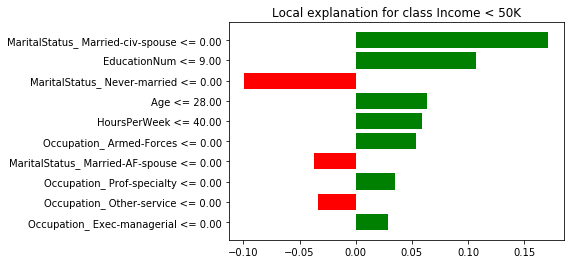

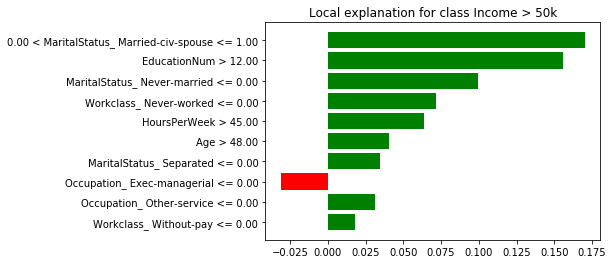

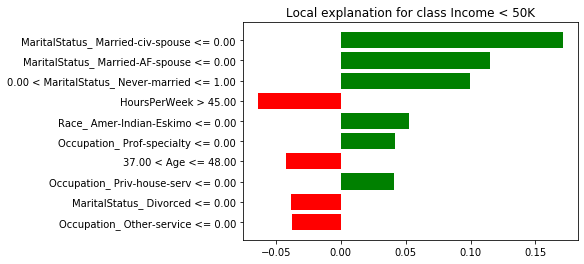

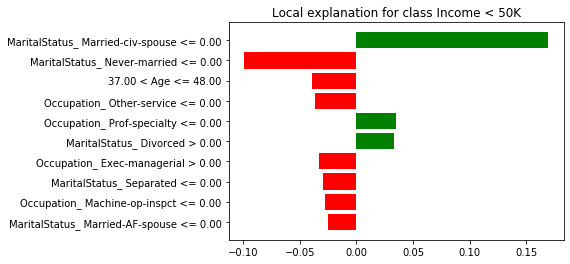

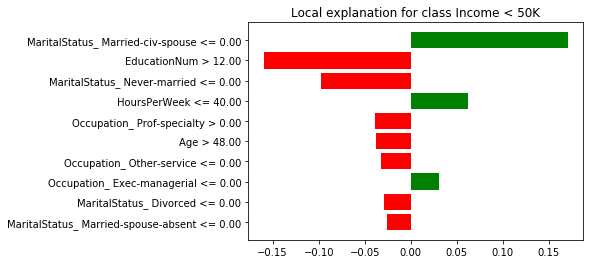

In [12]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, X_train.values, rf.predict_proba, sample_size=500, num_features=10, num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]


Intercept 0.7638324019589853
Prediction_local [0.74797188]
Right: 0.7222222222222222
Intercept 0.753497011586016
Prediction_local [0.76458924]
Right: 0.7777777777777778
Intercept 0.8776647489832745
Prediction_local [0.77804639]
Right: 0.8888888888888888
Intercept 0.6958462039506447
Prediction_local [0.76727504]
Right: 0.9444444444444444
Intercept 0.9444281595973715
Prediction_local [0.77912629]
Right: 0.6666666666666666
Intercept 0.7272011147814134
Prediction_local [0.75637686]
Right: 0.7222222222222222
Intercept 0.711300094037748
Prediction_local [0.76368235]
Right: 0.8333333333333334
Intercept 0.7618444114971313
Prediction_local [0.76641323]
Right: 0.8333333333333334
Intercept 0.7903014000841053
Prediction_local [0.74768738]
Right: 0.8333333333333334
Intercept 0.8114775066096798
Prediction_local [0.76061203]
Right: 0.8333333333333334
Intercept 0.8185524883592797
Prediction_local [0.74570155]
Right: 0.7222222222222222
Intercept 0.9678388485385683
Prediction_local [0.75398914]
Right: 0

Intercept 0.7481427749645355
Prediction_local [0.77732577]
Right: 0.8333333333333334
Intercept 0.7766575727914289
Prediction_local [0.76353882]
Right: 0.8333333333333334
Intercept 0.7564932165939893
Prediction_local [0.76856817]
Right: 0.7777777777777778
Intercept 0.6676487292140347
Prediction_local [0.76104282]
Right: 0.7777777777777778
Intercept 0.7249281543361563
Prediction_local [0.74705784]
Right: 0.8888888888888888
Intercept 0.7222098598309468
Prediction_local [0.76077339]
Right: 0.8888888888888888
Intercept 0.7177368649662077
Prediction_local [0.76616528]
Right: 0.7222222222222222
Intercept 0.7843106019456595
Prediction_local [0.7792068]
Right: 0.8333333333333334
Intercept 0.575763130764565
Prediction_local [0.75634862]
Right: 0.7222222222222222
Intercept 0.7498527850113961
Prediction_local [0.77796147]
Right: 0.7777777777777778
Intercept 0.8399003418696569
Prediction_local [0.76226069]
Right: 0.7777777777777778
Intercept 0.7068735297037635
Prediction_local [0.77073439]
Right: 0

Right: 0.6666666666666666
Intercept 0.8640231185629547
Prediction_local [0.7617237]
Right: 0.7777777777777778
Intercept 0.6965312063809059
Prediction_local [0.77053179]
Right: 0.6666666666666666
Intercept 0.7244724944292801
Prediction_local [0.74000753]
Right: 0.9444444444444444
Intercept 0.8476795281378802
Prediction_local [0.75985327]
Right: 0.9444444444444444
Intercept 0.7792851077000807
Prediction_local [0.75976836]
Right: 0.8888888888888888
Intercept 0.7587034139819246
Prediction_local [0.74168936]
Right: 0.6111111111111112
Intercept 0.9141622585525311
Prediction_local [0.7857127]
Right: 0.7777777777777778
Intercept 0.7301661996495881
Prediction_local [0.75985474]
Right: 0.7222222222222222
Intercept 0.7492656786316877
Prediction_local [0.74295131]
Right: 0.9444444444444444
Intercept 0.7255608223811528
Prediction_local [0.76409668]
Right: 0.7777777777777778
Intercept 0.6328641428481642
Prediction_local [0.76442776]
Right: 0.6666666666666666
Intercept 0.7097500023938571
Prediction_l

Intercept 0.8308004935236855
Prediction_local [0.75101724]
Right: 0.8888888888888888
Intercept 0.8962284441114927
Prediction_local [0.76209693]
Right: 0.9444444444444444
Intercept 0.7349718439592317
Prediction_local [0.78907755]
Right: 0.7222222222222222
Intercept 0.7747924048288872
Prediction_local [0.77835566]
Right: 0.6666666666666666
Intercept 0.592380235915979
Prediction_local [0.7748046]
Right: 0.8333333333333334
Intercept 0.6664022870041567
Prediction_local [0.76303165]
Right: 0.5555555555555556
Intercept 0.7800448654619222
Prediction_local [0.76777348]
Right: 0.6111111111111112
Intercept 0.7295359536768206
Prediction_local [0.76463156]
Right: 1.0
Intercept 0.8496287158164434
Prediction_local [0.78239701]
Right: 0.7222222222222222
Intercept 0.7204888233843308
Prediction_local [0.74469804]
Right: 0.6666666666666666
Intercept 0.6718520673159893
Prediction_local [0.75200434]
Right: 0.7777777777777778
Intercept 0.7814816193063167
Prediction_local [0.76293457]
Right: 0.83333333333333

Right: 0.7222222222222222
Intercept 0.7349006650474265
Prediction_local [0.74987685]
Right: 0.7222222222222222
Intercept 0.6661034755646965
Prediction_local [0.77143005]
Right: 0.7222222222222222
Intercept 0.5247641194189343
Prediction_local [0.76394485]
Right: 0.7777777777777778
Intercept 0.7737092022909142
Prediction_local [0.76697209]
Right: 0.7777777777777778
Intercept 0.759083925691151
Prediction_local [0.74271723]
Right: 0.8888888888888888
Intercept 0.8978862838882626
Prediction_local [0.73540452]
Right: 0.7777777777777778
Intercept 0.7676175446979407
Prediction_local [0.76093815]
Right: 0.7777777777777778
Intercept 0.5873351380576977
Prediction_local [0.74621084]
Right: 0.7222222222222222
Intercept 0.7108213857861534
Prediction_local [0.75156009]
Right: 0.7777777777777778
Intercept 0.8821464441749503
Prediction_local [0.76217519]
Right: 0.7222222222222222
Intercept 0.3622916963452828
Prediction_local [0.2266796]
Right: 0.5
Intercept 0.9068521115420333
Prediction_local [0.7568496

Right: 0.6111111111111112
Intercept 0.8684718882005861
Prediction_local [0.73646098]
Right: 0.8333333333333334
Intercept 0.14069282719220577
Prediction_local [0.25891408]
Right: 0.5
Intercept 0.7080637248502107
Prediction_local [0.76870936]
Right: 0.7777777777777778
Intercept 0.7246012418728239
Prediction_local [0.76201736]
Right: 0.6111111111111112
Intercept 0.7593609894323734
Prediction_local [0.76166481]
Right: 0.6111111111111112
Intercept 0.913169799945564
Prediction_local [0.74148338]
Right: 0.8888888888888888
Intercept 0.6201286653955829
Prediction_local [0.74911141]
Right: 0.6111111111111112
Intercept 0.17815474982464677
Prediction_local [0.24594356]
Right: 0.5
Intercept 0.7396420436938644
Prediction_local [0.76339738]
Right: 1.0
Intercept 0.7402174077311121
Prediction_local [0.75141119]
Right: 0.6666666666666666
Intercept 0.8157537282528987
Prediction_local [0.76161297]
Right: 0.7222222222222222
Intercept 0.7934103769610786
Prediction_local [0.77102663]
Right: 0.777777777777777

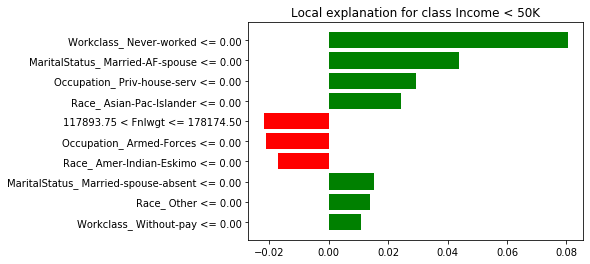

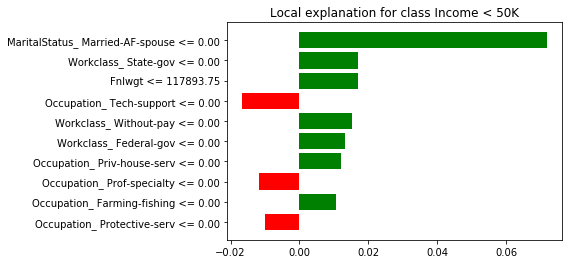

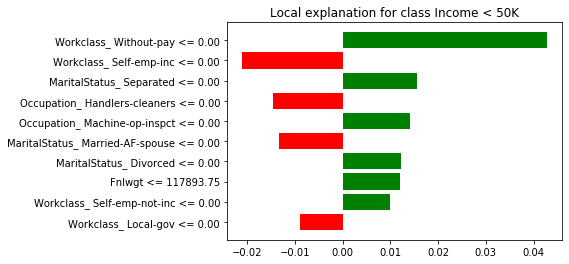

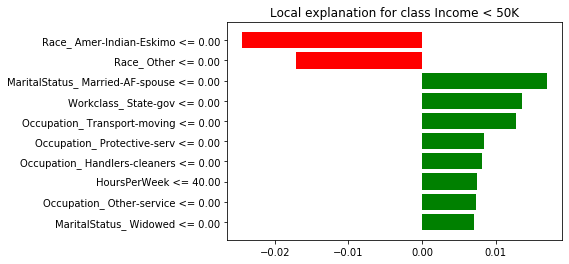

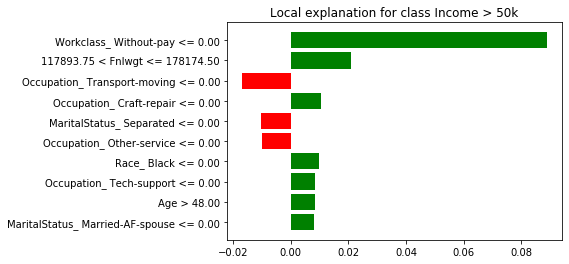

In [13]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, X_train.values, knn.predict_proba, sample_size=500, num_features=10, num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]


Intercept 0.708378590509028
Prediction_local [0.66837529]
Right: 0.5061788068684847
Intercept 0.16197681274760206
Prediction_local [0.38649539]
Right: 0.5067637763700795
Intercept 0.9289419233990424
Prediction_local [0.79617807]
Right: 0.7959557373668702
Intercept 0.6466458383972965
Prediction_local [1.00675181]
Right: 0.8875537407589148
Intercept 0.763707316098015
Prediction_local [0.75279342]
Right: 0.6996641500562717
Intercept 0.7658359461924688
Prediction_local [0.67949007]
Right: 0.5728853064626083
Intercept 0.6503819058115023
Prediction_local [1.00742943]
Right: 0.991409735104394
Intercept 0.7290485197494536
Prediction_local [0.6897569]
Right: 0.8123769580142836
Intercept 0.9047713389086147
Prediction_local [0.61879242]
Right: 0.5460721865884346
Intercept 0.8460666971973684
Prediction_local [0.62014736]
Right: 0.511576797487207
Intercept 0.861499297901402
Prediction_local [0.73407505]
Right: 0.7517209776987263
Intercept 0.656185914477542
Prediction_local [1.02061292]
Right: 0.944

Prediction_local [0.85032949]
Right: 0.8523384440189815
Intercept 0.7208826543913731
Prediction_local [0.90883597]
Right: 0.9794714916872463
Intercept 0.6501391635906003
Prediction_local [0.96051061]
Right: 0.8729177713286684
Intercept 0.7006836004238736
Prediction_local [0.89723401]
Right: 0.9779636584096756
Intercept 0.7570908728547473
Prediction_local [0.82831439]
Right: 0.7076652480958432
Intercept 0.07677882743537946
Prediction_local [0.43072313]
Right: 0.5414716041745885
Intercept 0.6876448895269922
Prediction_local [0.90090109]
Right: 0.9127131556984286
Intercept 0.590782062361461
Prediction_local [1.00579105]
Right: 0.9603638199902202
Intercept 0.6555161959431828
Prediction_local [0.90478854]
Right: 0.8944876279289284
Intercept 0.7487416363188629
Prediction_local [0.72743053]
Right: 0.6774739708584449
Intercept 0.8463628813281527
Prediction_local [0.61112296]
Right: 0.5282032640977126
Intercept 0.05863561201596337
Prediction_local [0.44429565]
Right: 0.5411781122983362
Intercep

Right: 0.9617980358127127
Intercept 0.8420897468387766
Prediction_local [0.79744852]
Right: 0.68691114630704
Intercept 0.6639634736841212
Prediction_local [0.83610367]
Right: 0.8273274142222566
Intercept 0.7484039998411207
Prediction_local [0.73014939]
Right: 0.5889460609637743
Intercept 0.8560833253913201
Prediction_local [0.70785597]
Right: 0.7694170512192845
Intercept 0.6145036771752567
Prediction_local [0.89190419]
Right: 0.9285577219499326
Intercept 0.7819189738131269
Prediction_local [0.7208007]
Right: 0.9268942448985782
Intercept 0.7749107019711399
Prediction_local [0.67796291]
Right: 0.8393714911669732
Intercept 0.590076274920805
Prediction_local [0.75534975]
Right: 0.8902637238806846
Intercept 0.6505785663690219
Prediction_local [0.80797535]
Right: 0.6807980289769874
Intercept 0.09007355530777904
Prediction_local [0.40960489]
Right: 0.514838563236828
Intercept 0.6762954953350164
Prediction_local [1.00398804]
Right: 0.9229244404886845
Intercept 0.8912245889893196
Prediction_loc

Prediction_local [0.96587127]
Right: 0.978410693219817
Intercept 0.7406144017673341
Prediction_local [0.71790814]
Right: 0.7427372655183572
Intercept 0.13061267960043396
Prediction_local [0.45624469]
Right: 0.6244739805201138
Intercept 0.748360584617299
Prediction_local [0.82875991]
Right: 0.8020680471445326
Intercept 0.7408493377218776
Prediction_local [0.75811149]
Right: 0.6521501343493951
Intercept 0.6056438254823088
Prediction_local [0.90101486]
Right: 0.8479625593518806
Intercept 0.8118114580240678
Prediction_local [0.71139265]
Right: 0.6191990533842752
Intercept 0.5665456471456645
Prediction_local [1.01027301]
Right: 0.9394480823078775
Intercept 0.9160973722412074
Prediction_local [0.61925302]
Right: 0.6571155359623355
Intercept 0.6884087916605656
Prediction_local [0.75416303]
Right: 0.8160262620996726
Intercept 0.8492814630869575
Prediction_local [0.71050302]
Right: 0.7152518336130065
Intercept 0.5906512262608425
Prediction_local [1.00679405]
Right: 0.9023672579213273
Intercept 

Right: 0.8111871003911953
Intercept 0.7253767280226291
Prediction_local [0.80804356]
Right: 0.7354285233124951
Intercept 0.57840329175913
Prediction_local [0.91132633]
Right: 0.8614523873064723
Intercept 0.132062346687845
Prediction_local [0.45890268]
Right: 0.6153493438198486
Intercept 0.7841536441547897
Prediction_local [0.84461913]
Right: 0.7246116945053935
Intercept 0.8947254702087075
Prediction_local [0.78632826]
Right: 0.718260982992045
Intercept 0.5553253397022102
Prediction_local [0.80668266]
Right: 0.8212297926222815
Intercept 0.5212475454680743
Prediction_local [1.01915026]
Right: 0.9924468746468228
Intercept 0.7041020781755698
Prediction_local [0.74292489]
Right: 0.770251019578993
Intercept 0.7702689485386528
Prediction_local [0.72120171]
Right: 0.5803820880255643
Intercept 0.9569791912164742
Prediction_local [0.60389988]
Right: 0.6248833950109589
Intercept 0.8476914791111814
Prediction_local [0.60562564]
Right: 0.6036649015825121
Intercept 0.5344586501333273
Prediction_loca

Prediction_local [0.97951924]
Right: 0.9509650919327046
Intercept 0.10235721046296134
Prediction_local [0.472403]
Right: 0.5976066584662482
Intercept 0.7335004737145376
Prediction_local [0.80660634]
Right: 0.7502916050760173
Intercept 1.0306217625158967
Prediction_local [0.69035771]
Right: 0.7172646216493653
Intercept 0.8944095287871212
Prediction_local [0.7105964]
Right: 0.6368912947538704
Intercept 0.5899012013659283
Prediction_local [0.96203582]
Right: 0.9081657580187827
Intercept 0.7669125890211471
Prediction_local [0.91641613]
Right: 0.8476038417719884
Intercept 0.7636703131735219
Prediction_local [0.81157311]
Right: 0.9313884512528354
Intercept 0.6272046676431644
Prediction_local [0.79412499]
Right: 0.90901349671473
Intercept 0.6088326552732892
Prediction_local [0.85379752]
Right: 0.8547518301180922
Intercept 0.5639361378133503
Prediction_local [1.00948519]
Right: 0.9919103749937856
Intercept 0.9876243044919971
Prediction_local [0.64091713]
Right: 0.6103434631116376
Intercept 0.8

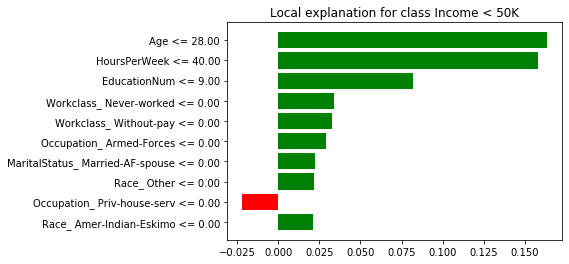

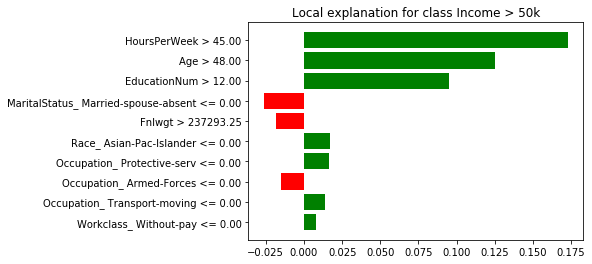

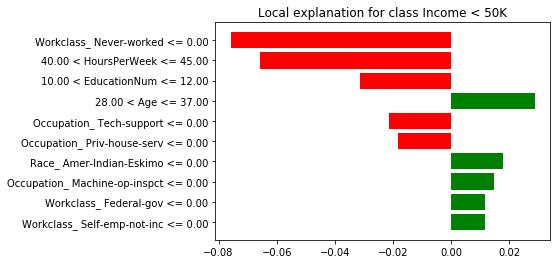

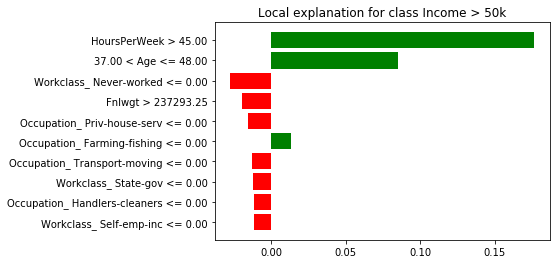

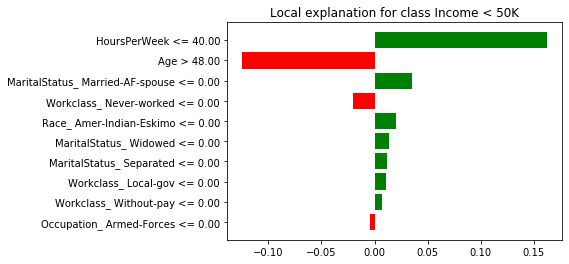

In [14]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, X_train.values, gnb.predict_proba, sample_size=500, num_features=10, num_exps_desired=5)
#Plot the 5 explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
# Make it into a dataframe
W_pick=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [this.available_labels()[0] for this in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(this.as_list(this.available_labels()[0])) for this in sp_obj.explanations]).fillna(0)
W['prediction'] = [this.available_labels()[0] for this in sp_obj.explanations]
